# Figure formats, interactivity and paired comparisons

::::{grid}

:::{grid-item-card}

**Lecture learning goals**
^^^

By the end of the lecture you will be able to:

1. Telling a story with data
2. Save figures outside the notebook
3. Visualize pair-wise differences using a slope plot
4. Creat interactive ggplots charts via plotly (not on the quiz) 
5. Create widget-based interactivity (not on the quiz)
6. Explain figure formats in the notebook (not on the quiz)

:::

:::{grid-item-card}

**Required activities**
^^^

After class:
- Review the lecture notes.
- Watch this [15 min video on paired comparisons](https://ubcca-my.sharepoint.com/:v:/g/personal/joel_ostblom_ubc_ca/Ed8Vfw1Jf39ErXwJPau9-30BqMYiV5-Bpoy8DaVKiPfgWg?e=ZxToLS)
- [Section 29 on how to tell a story with data](https://clauswilke.com/dataviz/telling-a-story.html). It is really important to read this chapter, it has some great details on how to tell a story with several examples.

:::
::::

**Lecture slides**

<html>
  <body>
    <iframe src="slides-lec8.pdf#zoom=80&&navpanes=0&statusbar=0&messages=0&pagemode=none" width="100%" height="475px" style="position: relative;z-index: 9999999;">
    </iframe>
  </body>
</html>

## Saving figures

### Py

In addition to exporting an entire notebook,
how can we save individual figures via Altair and ggplot?

Saving as HTML ensures that any interactive features are still present in the saved file.

In [1]:
import altair as alt
from vega_datasets import data

cars = data.cars()

mpg_weight = alt.Chart(cars).mark_circle().encode(
    x='Weight_in_lbs',
    y='Miles_per_Gallon',
    color='Origin',
    tooltip=['Name', 'Origin', 'Horsepower', 'Miles_per_Gallon']
)
mpg_weight

alt.Chart(...)

In [2]:
mpg_weight.save('mpg_weight.html')

This means we could send this HTML file to anyone (e.g. as an email attachment)
and they could open it on their computer and still have the interactive elements loaded in the browser,
since they don't require a Python server running.
You could also upload this file to a static web page generator such as GitHub pages
and have it served online
(rename the chart `index.html` if you want it to be displayed as the landing page on GitHub pages),
e.g. as I have done here https://github.com/joelostblom/altair-demos 
(live at https://joelostblom.github.io/altair-demos/).

It is also possible to save as non-interactive formats 
such as png (raster) and svg (vector).
Internally this relies on another packages called vl-convert, which we have installed in the 531 environment.

In [3]:
mpg_weight.save('mpg_weight.png')

The resolution/size of the saved image can be controlled via the `scale_factor` parameter.

In [4]:
mpg_weight.save('mpg_weight-hires.png', scale_factor=3)

You might have noticed that Altair charts do not show up on GitHub when you e.g. review a PR.
This is the same for all interactive charting libraries and it is because GitHub does not load interactive features,
and only displays static images.
Altair can include a static image as a fallback for each chart you make,
so that you still have the interactive chart in your JupyterLab or VS code,
but in environments that can't display these (such as GitHub)
and image will be used instead.

In [5]:
# Run the following line to enable the backup image that will make charts appear on GitHub as well
# alt.renderers.enable('mimetype')

### R

In [6]:
# Load the R cell magic
%load_ext rpy2.ipython

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


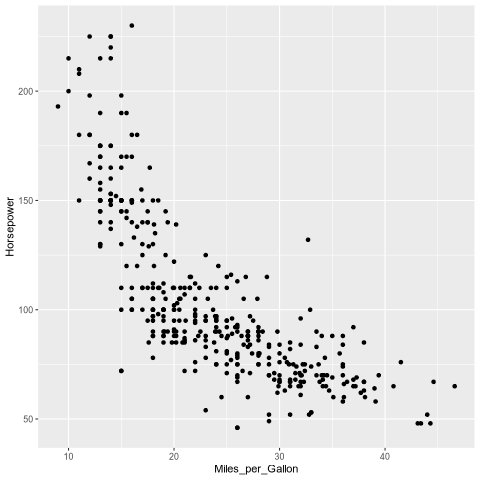

In [7]:
%%R -i cars
library(tidyverse)

mpg_weight <- ggplot(cars) +
    aes(Miles_per_Gallon, Horsepower) +
    geom_point()
mpg_weight

The `ggsave` functions saves the most recent plot to a file.

In [8]:
%%R
ggsave('mpg_weight-r.png')

Saving 6.67 x 6.67 in image


You can also specify which figure to save.

In [9]:
%%R
ggsave('mpg_weight-r.png', mpg_weight)

Saving 6.67 x 6.67 in image


Setting the dpi controls the resolution of the saved figure.

In [10]:
%%R
ggsave('mpg_weight-hires-r.png', dpi=96)

Saving 6.67 x 6.67 in image


You can save to PDF and SVG as well.
Note that saving to svg requires the `svglite` package.

In [11]:
%%R
ggsave('mpg_weight-r.pdf', mpg_weight)

Saving 6.67 x 6.67 in image


## Pairwise comparisons

### R

Let's start by looking at your results from the world health quiz we did in lab 1!
Below, I read in the data and assign a label for whether each student
had a positive or negative outlook of their own results
compared to their estimation of the class average.

In [12]:
%%R -o scores,scores_this_year
library(tidyverse)

theme_set(theme_grey(base_size=18))

scores_raw <- read_csv('data/students-gapminder.csv')
colnames(scores_raw) <- c('time', 'student_score', 'estimated_class_mean')
scores <- scores_raw |>
    mutate(
        diff = student_score - estimated_class_mean,
        self_belief = case_when(
            diff == 0 ~ 'neutral',
            diff < 0 ~ 'negative',
            diff > 0 ~ 'positive'
        ),
        year = time |> lubridate::parse_date_time(order='mdY HMS') |> lubridate::year()
    ) |>
    # Only keep the scores from October which is when we run the survey in MDS. I think the other scores are from DSCI 320 in Jan
    filter((time |> lubridate::parse_date_time(order='mdY HMS') |> lubridate::month()) == 10) |>
    filter(year > 2020) |>
    pivot_longer(
        !c(time, year, self_belief, diff),  # time is kept as a student ID
        values_to = 'score',
        names_to = 'score_type'
    ) |>
    mutate(score_type = factor(score_type, levels = c('student_score', 'estimated_class_mean'))) |>
    arrange(desc(diff))
scores_this_year <- scores |> filter(year == 2023)
scores_this_year

Rows: 269 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Timestamp
dbl (2): Please enter how many questions you answered correctly on the test ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 94 × 6
   time                 diff self_belief  year score_type           score
   <chr>               <dbl> <chr>       <dbl> <fct>                <dbl>
 1 10/10/2023 14:59:28  3.33 positive     2023 student_score         7   
 2 10/10/2023 14:59:28  3.33 positive     2023 estimated_class_mean  3.67
 3 10/6/2023 10:09:24   3    positive     2023 student_score        12   
 4 10/6/2023 10:09:24   3    positive     2023 estimated_class_mean  9   
 5 10/10/2023 14:18:46  3    positive     2023 student_score        12   
 6 10/10/2023 14:18:46  3    positive     2023 estimated_class_mean  9   
 7 10/12/2023 15:5

We could make a distribution plot,
such as a KDE for the students score and estimated class score.
From this plot we can see that on average students seemed to believe their classmates scored better,
but we don't know if this is because all students thought this,
or some thought their classmates scored much better while others thought it was about the same.

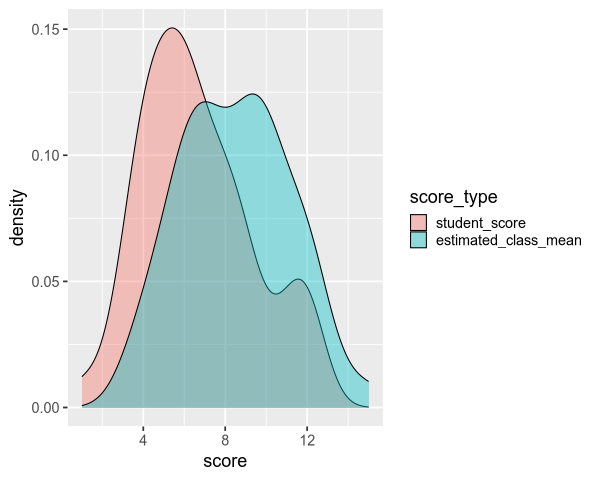

In [13]:
%%R -w 600
ggplot(scores_this_year) +
    aes(x = score,
       fill = score_type) +
    geom_density(alpha=0.4)

Drawing out each students score and estimated score,
and then connecting them with a line allows us to easily see
the trends in how many students thought their score was better or worse than the class
(this is sometimes called a "slope plot").

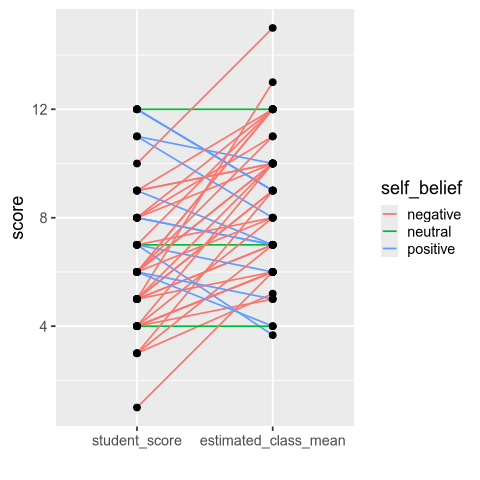

In [14]:
%%R
ggplot(scores_this_year) +
    aes(x = score_type,
        y = score,
       group = time) +
    geom_line(aes(color = self_belief), size = 0.8) + 
    geom_point(size=3) + labs(x='')

To make it easier to see how much better or worse each student score is compared to the class estimate,
we can color the lines by the difference and set a diverging colormap.
However,
this can become quite noisy
and it is not as easy to pick up the high level patterns as in the simpler visualization above
(and the white lines are hard to see).

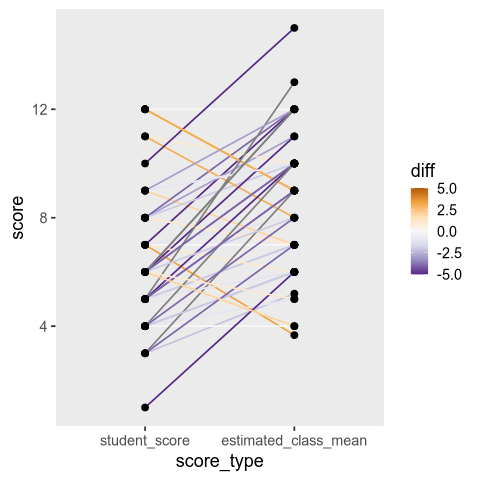

In [15]:
%%R
ggplot(scores_this_year) +
    aes(x = score_type,
        y = score,
       group = time) +
    geom_line(aes(color = diff), size = 0.8) + 
    geom_point(size=3) +
    scale_color_distiller(palette = 'PuOr', limits = c(-5, 5)) +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank())

Another way we could have visualized these differences would have been as a bar plot of the differences,
but we would not know the students' score, just the difference.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


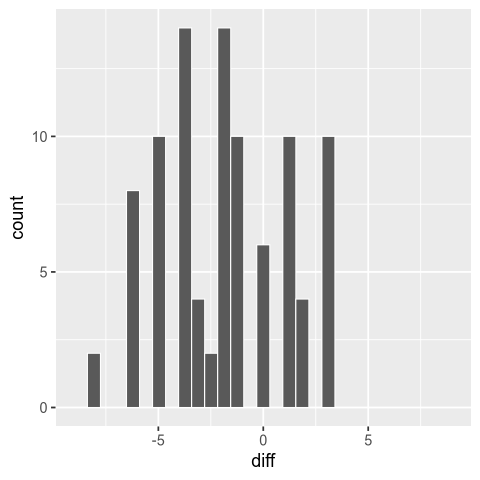

In [16]:
%%R
ggplot(scores_this_year) +
    aes(x = diff) +
    geom_histogram(color='white') +
    scale_x_continuous(limits=c(-9, 9))

A scatter plot could also work for this comparison,
ideally with a diagonal line at zero difference.

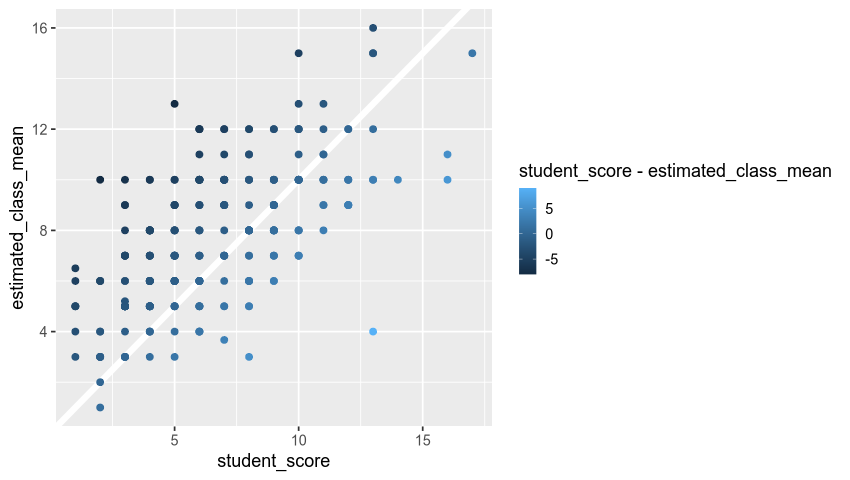

In [17]:
%%R -w 850
p <- ggplot(scores_raw) +
    aes(x = student_score,
        y = estimated_class_mean,
       color = student_score - estimated_class_mean) +
    geom_abline(slope = 1, intercept = 0, color = 'white', size = 3) +
    geom_point(size = 3)
p

### Py

In [18]:
points = alt.Chart(scores_this_year).mark_circle(size=50, color='black', opacity=1).encode(
    alt.X('score_type').axis(labelAngle=0),
    alt.Y('score'),
    alt.Detail('time')
).properties(
    width=300
)
(points.mark_line(size=1.4, opacity=0.9).encode(alt.Color('self_belief').scale(range=['coral', 'green', 'steelblue'])) + points)

alt.LayerChart(...)

In [19]:
points = alt.Chart(scores_this_year).mark_circle(size=50, color='black', opacity=1).encode(
    alt.X('score_type'),
    alt.Y('score'),
    alt.Detail('time')).properties(width=300)
points.mark_line(size=1.8, opacity=0.8).encode(alt.Color('diff', scale=alt.Scale(scheme='blueorange', domain=(-6, 6)))) + points

alt.LayerChart(...)

## Interactivity with plotly in R (not on the quiz)

Everything from here and onwards will not be on the quiz,
but is included in case your're interesting in learning more about the powerful interactive visualization we can build.
You can find even more examples of interactive elements
such as search boxes and checkboxes
in [the interactive secction of the Altair docs](https://altair-viz.github.io/user_guide/interactions.html#composing-multiple-selections).

### Making ggplot interactive with `ggplotly()`

[Plotly](https://plotly.com/ggplot2/getting-started/) is a separate library that can be used to convert ggplot charts
into interactive versions.
Plotly does not have an easily composable interaction grammar,
but instead makes a few specific functions available for us to use.
One of these lets us create animations,
which is very cool!
Plotly interactions work out of the box in RStudio (via the Htmlwidgets library),
and will work in the knitted notebooks.
They should also work in JupyterLab if you first install the [JupyterLab plotly extensions](https://plotly.com/python/getting-started/#jupyterlab-support).
They will not work in these lecture notes however, so you will need to use one of the approaches above to try it out.

To make a basic interactive version of a chart,
giving it a tooltip on hover,
a clickable legend,
and the ability to zoom,
we can wrap our ggplot chart in the function `ggplotly()`:

```r
library(ggplot2)
library(plotly)
library(dplyr)

p <- ggplot(msleep) +
    aes(x = bodywt,
        y = sleep_total,
        color = vore,
        text = name) +
    geom_point() +
    scale_x_log10() +
    ggthemes::scale_color_tableau()

ggplotly(p)
```

![](img/ggplotly-legend.png)

### Sharing legend interactivity

As we saw above,
we get zooming and interactive legends by default in plotly.
If we put two plots together in a plotly `subplot` layout
they share an interactive legend
(although with doubled glyphs in the legend).
There is also [a highlight function
that can be used to drive non-legend based selection between two plots](https://plotly-r.com/client-side-linking.html).


```r
p <- ggplot(msleep) +
    aes(y = vore,
        fill = vore) +
    geom_bar(width = 0.6) +
    ggthemes::scale_fill_tableau()
p1 <- ggplotly(p, tooltip = 'text') %>% layout(dragmode = 'select')

p <- ggplot(msleep) +
    aes(x = bodywt,
        y = sleep_total,
        color = vore,
        text = name) +
    geom_point() +
    scale_x_log10() +
    ggthemes::scale_color_tableau()
p2 <- ggplotly(p, tooltip = 'text') %>% layout(dragmode = 'select')

subplot(p1, p2)
```

![](img/ggplotly-shared-legend.png)

### Rangeslider

There is a built-in function for creating a small plot ([a rangeslider](https://plotly-r.com/improving-ggplotly.html))
that can be used as a zoom widget of the bigger plot.

```r
library(babynames)

nms <- filter(babynames, name %in% c("Sam", "Alex"))
range_p <- ggplot(nms) + 
    geom_line(aes(year, prop, color = sex, linetype = name))
  
ggplotly(range_p, dynamicTicks = TRUE) %>%
    rangeslider() %>%
    layout(hovermode = "x")
```

![](img/ggplotly-rangeslider.png)

### Animations!

Animations are easily created by passing a column to the `frame` aesthetic in ggplot.

```r
library(gapminder)

gap_p <- ggplot(gapminder, aes(gdpPercap, lifeExp, color = continent)) +
  geom_point(aes(size = pop, frame = year, ids = country)) +
  scale_x_log10()

ggplotly(gap_p)
```

![](img/ggplotly-animation.png)

### Dropdowns

[Dropdowns are a bit verbose to use with plotly](https://plotly.com/r/dropdowns/)
and [they cannot be used with ggpltoly to dynamically query and filter the data](https://github.com/ropensci/plotly/issues/803#issuecomment-264042783)
as we saw with the Altair plots.
They could be used to control properties of the plot aesthetics 
such as marker color or which column's plot is shown, [the same goes for sliders](https://plotly.com/r/sliders/))
here is an example of the latter with ggplotly:

```r
dat <- mtcars
dat$cyl <- factor(dat$cyl)
dat$car <- rownames(mtcars)

dat %>% 
  tidyr::pivot_longer(c(mpg, hp, qsec)) %>% 
  plot_ly(x = ~car, y = ~value, color = ~cyl, symbol = ~name) %>%
  add_trace(type='scatter', mode='markers', name = ~cyl) %>% 
  layout(
    updatemenus = list(
      list(
        type = "list",
        label = 'Category',
        buttons = list(
          list(method = "restyle",
               args = list('visible', c(TRUE, FALSE, FALSE)),
               label = "hp"),
          list(method = "restyle",
               args = list('visible', c(FALSE, TRUE, FALSE)),
               label = "mpg"),
          list(method = "restyle",
               args = list('visible', c(FALSE, FALSE, TRUE)),
               label = "qsec")
        )
      )
    )
  )
```

![](img/ggplotly-dropdown.png)

## Bindings different elements to selection events in Altair (not on the quiz)

### Reading in data

In [20]:
import altair as alt
import pandas as pd
from vega_datasets import data

# Simplify working with large datasets in Altair
alt.data_transformers.enable('vegafusion')

# Load the R cell magic
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [21]:
movies = (
    data.movies()
    .drop(columns=['US_DVD_Sales', 'Director', 'Source', 'Creative_Type'])
    .dropna(subset=['Running_Time_min', 'Major_Genre', 'Rotten_Tomatoes_Rating', 'IMDB_Rating', 'MPAA_Rating'])
    .assign(
        Release_Year=lambda df: pd.to_datetime(df['Release_Date']).dt.year,
        Title=lambda df: df['Title'].astype(str) 
    )
    .reset_index(drop=True))
movies

,Title,US_Gross,Worldwide_Gross,Production_Budget,Release_Date,MPAA_Rating,Running_Time_min,Distributor,Major_Genre,Rotten_Tomatoes_Rating,IMDB_Rating,IMDB_Votes,Release_Year
0,Broken Arrow,70645997.0,148345997.0,65000000.0,Feb 09 1996,R,108.0,20th Century Fox,Action,55.0,5.8,33584.0,1996
1,Brazil,9929135.0,9929135.0,15000000.0,Dec 18 1985,R,136.0,Universal,Black Comedy,98.0,8.0,76635.0,1985
2,The Cable Guy,60240295.0,102825796.0,47000000.0,Jun 14 1996,PG-13,95.0,Sony Pictures,Comedy,52.0,5.8,51109.0,1996
3,Chain Reaction,21226204.0,60209334.0,55000000.0,Aug 02 1996,PG-13,106.0,20th Century Fox,Action,13.0,5.2,15817.0,1996
4,City Hall,20278055.0,20278055.0,40000000.0,Feb 16 1996,R,111.0,Sony Pictures,Drama,55.0,6.1,9908.0,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,Zoolander,45172250.0,60780981.0,28000000.0,Sep 28 2001,PG-13,89.0,Paramount Pictures,Comedy,62.0,6.4,69296.0,2001
974,Zombieland,75590286.0,98690286.0,23600000.0,Oct 02 2009,R,87.0,Sony Pictures,Comedy,89.0,7.8,81629.0,2009
975,Zack and Miri Make a Porno,31452765.0,36851125.0,24000000.0,Oct 31 2008,R,101.0,Weinstein Co.,Comedy,65.0,7.0,55687.0,2008
976,The Legend of Zorro,45575336.0,141475336.0,80000000.0,Oct 28 2005,PG,129.0,Sony Pictures,Adventure,26.0,5.7,21161.0,2005


In [22]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   978 non-null    object 
 1   US_Gross                978 non-null    float64
 2   Worldwide_Gross         978 non-null    float64
 3   Production_Budget       977 non-null    float64
 4   Release_Date            978 non-null    object 
 5   MPAA_Rating             978 non-null    object 
 6   Running_Time_min        978 non-null    float64
 7   Distributor             977 non-null    object 
 8   Major_Genre             978 non-null    object 
 9   Rotten_Tomatoes_Rating  978 non-null    float64
 10  IMDB_Rating             978 non-null    float64
 11  IMDB_Votes              978 non-null    float64
 12  Release_Year            978 non-null    int32  
dtypes: float64(7), int32(1), object(5)
memory usage: 95.6+ KB


### Legends

We saw before how we could use the `bind` parameter 
of an altair selection
to link it to the legend of the plot.

In [23]:
select_genre = alt.selection_point(
    fields=['Major_Genre'], # limit selection to the Major_Genre field
    bind='legend'
)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    color='Major_Genre',
    opacity=alt.condition(select_genre, alt.value(0.7), alt.value(0.1))
).add_params(
    select_genre
)

alt.Chart(...)

### Dropdowns

Binding to the legend doesn't work that well in this case
since there are so many colors that the plot looks a bit messy.
Instead,
we could create a dropdown selection widget directly in Altair (`alt.binding_select`)
to let us choose categories without coloring the points.
Instead of binding `alt.selection_point` to the legend
we can pass along the dropdown we just created.

In [24]:
# The drop down requires an array of options, here we sort the genres alphabeitcally
genres = sorted(movies['Major_Genre'].unique())
dropdown = alt.binding_select(options=genres)

select_genre = alt.selection_point(
    fields=['Major_Genre'],
    bind=dropdown
)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(select_genre, alt.value(0.7), alt.value(0.1))
).add_params(
    select_genre
)

alt.Chart(...)

Let's give our dropdown a better name
and set the default value for the selection.

In [25]:
# The drop down requires an array of options, here we sort the genres alphabeitcally
genres = sorted(movies['Major_Genre'].unique())
dropdown = alt.binding_select(name='Genre ', options=genres)

select_genre = alt.selection_point(
    fields=['Major_Genre'],
    bind=dropdown,
    value=[{'Major_Genre': 'Comedy'}])

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(select_genre, alt.value(0.7), alt.value(0.1))
).add_params(
    select_genre
)

alt.Chart(...)

### Dropdown and radio buttons

We could also add multiple widgets together,
by binding them to different fields in the selection.
Here we're adding a radio button for the MPAA rating to the plot above.

In [26]:
# The drop down requires an array of options, here we sort the genres alphabetically
genres = sorted(movies['Major_Genre'].unique())
dropdown_genre = alt.binding_select(name='Genre ', options=genres)

mpaa_rating = sorted(movies['MPAA_Rating'].unique())
dropdown_mpaa = alt.binding_radio(name='MPAA Rating ', options=mpaa_rating)

select_genre_and_mpaa = alt.selection_point(
    fields=['Major_Genre', 'MPAA_Rating'],
    bind={'Major_Genre': dropdown_genre, 'MPAA_Rating': dropdown_mpaa}
)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(select_genre_and_mpaa, alt.value(0.7), alt.value(0.1))
).add_params(
    select_genre_and_mpaa
)

alt.Chart(...)

Here it would makes sense to sort the ratings according to their natural order
instead of alphabetically, but they are roughly the same.

### Slider

In addition to dropdowns and add radio buttons we can add sliders, and checkboxes,
but there are no multiselection dropdown or range sliders.
For multiple selections, we can instead use `selection_multi` on other plots or legends,
and for range sliders, we can use the `selection_interval` on another plot.

Let's explore the slider.

In [27]:
slider = alt.binding_range(name='Tomatometer ')
select_rating = alt.selection_point(
    fields=['Rotten_Tomatoes_Rating'],
    bind=slider
)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(select_rating, alt.value(0.7), alt.value(0.1))
).add_params(
    select_rating
)

alt.Chart(...)

The default behavior is to only filter points that are the exact values of the slider.
This is useful for selection widgets like the dropdown,
but for the slider we want to make comparisons
such as bigger and smaller than.
We can use `alt.datum` for this,
which let's us use columns from the data
inside comparisons and more complex expression in Altair,
where it is not possible to write the column name only
(this makes it clear that is the the column name
and not just a string of the same name
that is referenced in the expression).

In [28]:
slider = alt.binding_range(name='Tomatometer ')
select_rating = alt.selection_point(
    fields=['Rotten_Tomatoes_Rating'],
    bind=slider
)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(
        alt.datum.Rotten_Tomatoes_Rating < select_rating.Rotten_Tomatoes_Rating,
        alt.value(0.7), alt.value(0.1))
).add_params(
    select_rating
)

alt.Chart(...)

We can set an explicit start value to avoid that all points appear unselected at the start,
as well as define the range and step size for the slider.

In [29]:
slider = alt.binding_range(name='Tomatometer ', min=10, max=60, step=5)
select_rating = alt.selection_point(
    fields=['Rotten_Tomatoes_Rating'],
    bind=slider,
    value=[{'Rotten_Tomatoes_Rating': 15}]
)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(
        alt.datum.Rotten_Tomatoes_Rating < select_rating.Rotten_Tomatoes_Rating,
        alt.value(0.7), alt.value(0.1))
).add_params(
    select_rating
)

alt.Chart(...)

A more useful function of our slider would be to filter for the year.

In [30]:
slider = alt.binding_range(
    name='Year ', step=1,
    min=movies['Release_Year'].min(), max=movies['Release_Year'].max())
select_rating = alt.selection_point(
    fields=['Release_Year'],
    bind=slider,
    value=[{'Release_Year': 2000}]
)

alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(
        alt.datum.Release_Year < select_rating.Release_Year,
        alt.value(0.7), alt.value(0.1))
).add_params(
    select_rating
)

alt.Chart(...)

### Driving slider-like selections from another plot instead

The plot above has several problems.
Since there is no range slider,
we would have to add a second slider to filter a range of values.
And it is a bit unclear why the max is 2040,
I guess there is a mislabeled movie,
but can't be sure.
I also don't get any information about which years have the most releases.

Due to Altair's consistent interaction grammar,
we can bind a similar selection event
to a bar chart (or any chart type we want) instead of the slider,
and change it to an interval to be able to select a range of points.

In [31]:
select_year = alt.selection_point(
    fields=['Release_Year'],
    value=[{'Release_Year': 2000}]
)

bar_slider = alt.Chart(movies).mark_bar().encode(
    x='Release_Year',
    y='count()').properties(height=50).add_params(select_year)

scatter_plot = alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(
        select_year,
        alt.value(0.7), alt.value(0.1)
    )
)

scatter_plot & bar_slider

alt.VConcatChart(...)

It is great to be able to see where most movies are along the year axis!
This bar plot is a much more informative driver of the selection event
compared to the slider.

Now let's switch it over an interval selection,
I will change from `fields` to `encodings` here,
to indicate that we only want to drag the interval along the x-axis
and use whatever column is on that axis.
I will also fix the formatting of the x-axis
to display years properly by using the `year()`
function on the date column directly
(similar to how we have used `sum()`, `mean()` etc before).

In [32]:
select_year = alt.selection_interval(encodings=['x'])

bar_slider = alt.Chart(movies).mark_bar().encode(
    x='year(Release_Date)',
    y='count()').properties(height=50).add_params(select_year)

scatter_plot = alt.Chart(movies).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(
        select_year,
        alt.value(0.7), alt.value(0.1)
    )
)

scatter_plot & bar_slider

alt.VConcatChart(...)

This is related to the discussion we had in the first lecture around 
"what is a dashboard",
including examples on how shopping sites etc
have many of the features that we traditionally associate with dashboards.

Now let's ask ourselves "What is a widget?".
Is there any distinct difference between this small plot
and the slider that disqualifies it from being called a widget?
At this point,
I think is mostly comes down to looks,
so let's make our bar selector appear more "widgety".

In [33]:
select_year = alt.selection_interval(encodings=['x'])

# Filter out a few of the extreme value to make it look better
movies_fewer_years = movies.query('1994 < Release_Year < 2030')
bar_slider = alt.Chart(movies_fewer_years).mark_bar().encode(
    alt.X('year(Release_Date)', title='', axis=alt.Axis(grid=False)),
    alt.Y('count()', title='', axis=None)
).properties(
    height=20,
    width=100
).add_params(
    select_year
)

scatter_plot = alt.Chart(movies_fewer_years).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    tooltip='Title',
    opacity=alt.condition(
        select_year,
        alt.value(0.7), alt.value(0.1)
    )
)

(scatter_plot & bar_slider).configure_view(strokeWidth=0)

alt.VConcatChart(...)

[If it looks like a duck... ](https://en.wikipedia.org/wiki/Duck_test) then it is a widget to me!

### Multi-dimensional legends

Realizing the mutual properties between what we traditionally refer to as plots and legends,
means that it is almost only your imagination that sets the limits.
For example,
legends are usually one-dimensional,
but it doesn't have to be that way!
Let's make a three dimensional legend and link two of those dimensions to a selection.
We will use the [Altair composition operator](https://altair-viz.github.io/user_guide/interactions.html#composing-multiple-selections) `&`
for triggering the condition only at the intersection of all selections.

In [34]:
# To make the final result  bit more elegant, I am filtering out a few low count categories
top_genres = movies_fewer_years['Major_Genre'].value_counts()[:5].index
mpaa_rating_clean = [rate for rate in mpaa_rating if rate != 'Not Rated']
movies_clean = movies_fewer_years.query('Major_Genre in @top_genres and MPAA_Rating in @mpaa_rating_clean')

select_genre_and_mpaa = alt.selection_point(
    fields=['Major_Genre', 'MPAA_Rating'],
    empty=True,
    nearest=True)

multidim_legend = alt.Chart(movies_clean, title=alt.TitleParams(text='Genre and Rating', fontSize=10, dx=-15)).mark_point(filled=True).encode(
    alt.X('MPAA_Rating', title=''),
    alt.Y('Major_Genre', title='', axis=alt.Axis(orient='right')),
    alt.Size('count()', legend=None),
    alt.Color('Major_Genre', legend=None),
    opacity=alt.condition(select_genre_and_mpaa, alt.value(1), alt.value(0.2))
#     alt.Shape('MPAA_Rating', legend=None)
).add_params(select_genre_and_mpaa).properties(width=100)


select_year = alt.selection_interval(empty=True, encodings=['x'])

# Filter out a few of the extreme value to make it look better
bar_slider = (
    alt.Chart(movies_clean, title=alt.TitleParams(text='Production year', fontSize=10, dx=-15)).mark_bar().encode(
    alt.X('year(Release_Date)', title='', axis=alt.Axis(grid=False),
          scale=alt.Scale(domain=[1995, 2012])),
    alt.Y('count()', title='', axis=None))
    .properties(height=20, width=100)
    .add_params(select_year))

select_time = alt.selection_interval(empty=True, encodings=['x'])

# Filter out a few of the extreme value to make it look better
bar_slider_time = (
    alt.Chart(movies_clean, title=alt.TitleParams(text='Running time', fontSize=10, dx=-15)).mark_bar().encode(
    alt.X('Running_Time_min', title='', axis=alt.Axis(grid=False)),
    alt.Y('count()', title='', axis=None))
    .properties(height=20, width=100)
    .add_params(select_time))

scatter_plot = alt.Chart(movies_clean).mark_circle().encode(
    x='Rotten_Tomatoes_Rating',
    y='IMDB_Rating',
    color='Major_Genre',
    tooltip='Title',
    opacity=alt.condition(
        select_year & select_genre_and_mpaa & select_time,
        alt.value(0.7), alt.value(0.1)))

(scatter_plot | (bar_slider & bar_slider_time & multidim_legend)).configure_view(stroke=None)

alt.HConcatChart(...)

In [35]:
(scatter_plot | (bar_slider & bar_slider_time & multidim_legend)).configure_view(stroke=None).save('chart-widgets.html')

Building advanced layouts like this is not the most common use case for notebook interactivity
when it is focused on exploration.
However,
it can be nice to know how to implement these features
when creating a more polished notebook to share with someone.